<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PlotEnergies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [25]:
# !pip install -q https://github.com/conda-incubator/condacolab/archive/main.zip
# import condacolab
# condacolab.install()

In [26]:
%%capture
import sys

!{sys.executable} -m pip install jscatter
!{sys.executable} -m pip install ipympl
#!{sys.executable} -m pip install -i https://pypi.anaconda.org/ambermd/simple pytraj 
#!mamba install -c conda-forge openbabel -y
#!pip install --upgrade MDAnalysis
#!mamba install -c conda-forge ambertools -y

# Import libraries

In [41]:
%matplotlib ipympl

import jscatter as js
import matplotlib.pyplot as plt
import os 
import numpy as np
from google.colab import output
import pandas as pd
import seaborn as sb 
import matplotlib.gridspec as gridspec

output.enable_custom_widget_manager()

# Import Files

In [28]:
#@title Import files from google
#from google.colab import drive

#drive.flush_and_unmount()
#drive.mount('/content/drive', force_remount=False)

In [33]:
#@title Github

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

Cloning into 'MD-SCPI'...
remote: Enumerating objects: 2506, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 2506 (delta 5), reused 26 (delta 5), pack-reused 2466
Receiving objects: 100% (2506/2506), 995.47 MiB | 39.11 MiB/s, done.
Resolving deltas: 100% (921/921), done.
Updating files: 100% (907/907), done.


In [34]:
#@title Defining Variables
files = ['AS4', 'COL', 'STR', 'AS4_mut', 'COL_mut', 'STR_mut']
work_directories = ['/content/MD-SCPI/PDBs/MD/{}/data'.format(file) for file in files]

files = os.listdir(work_directories[0])
ligand_files = np.array([file for file in files if 'ligand' in file])
[print(i, ligand_files[i]) for i in range(ligand_files.size)];

ligand_files_interesting = ['ligand-protein.dat', 'ligand-environment.dat', 'ligand-GLN51.dat', 'ligand-ASN45.dat', 'ligand-ARG92.dat', 
                            'ligand-SER118.dat', 'ligand-HH22.dat', 'ligand-THR222.dat', 'ligand-SER85.dat']
colors = ['black', 'blue', 'orange', 'red', 'green', 'purple', 'olive', 'pink', 'royalblue', 'teal']

dt = 0.002*1e3  # ste time in ns

0 ligand-THR222.dat
1 ligand-ASN45.dat
2 ligand-SER85.dat
3 ligand-HH22.dat
4 ligand-protein.dat
5 ligand-solvent.dat
6 ligand-GLN51.dat
7 ligand-ARG92.dat
8 ligand-SER118.dat
9 ligand-environment.dat


In [39]:
#@title Defining Auxiliar Functions
def SubPlot(gs0, i, j, ligand, ligand_files_interesting, bins_cum, bins, ncol=2, double_legend=False, legend_position=(0.2, .525)):
  directory = '/content/MD-SCPI/PDBs/MD/{}/data'.format(ligand)
  gs00 = gs0[i,j].subgridspec(1, 3, wspace=0.05)
  ax_main = plt.subplot(gs00[0:2, :2])
  ax_yDist = plt.subplot(gs00[:1, 2],sharey=ax_main)
  ax_main.grid(True); ax_yDist.grid(axis='y')

  c, lines, lines1 = 0, [], []
  for i in range(len(ligand_files_interesting)):
    #print(ligand, ligand_files_interesting[i])
    data=js.dA(os.path.join(directory, ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    line1, = ax_main.plot(x,y,'-', color=colors[i], alpha=0.8, label=round(np.average(y),3))#ligand_files_interesting[i][7:-4])
    lines.append(line1)
    
    if double_legend:
      line2, = ax_main.plot(x,y+1e4, '-', label=ligand_files_interesting[i][7:-4], color=colors[i], alpha=0.8)
      lines1.append(line2);
    
    #ax_yDist.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist = ax_yDist.twiny()
    ax_yCumDist.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    
    c+=1

  ax_main.set_xlabel("Time (ns)", fontsize='16');   ax_main.set_ylabel("Energy (kcal/mol)", fontsize='16')
  
  legend = ax_main.legend(handles=lines, bbox_to_anchor=legend_position, title='Average', fontsize='12', ncol=ncol, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  ax_main.add_artist(legend)
  if double_legend:
    ax_main.legend(handles=lines1, bbox_to_anchor=(2.05, .7), title='Interacting\n     With', fontsize='18', borderaxespad=0., title_fontproperties={'weight':'bold', 'size':'20'})

  return ax_main, ax_yDist

def RemoveBox(ax):
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

def PlotEnergiesShort(work_directories, figsize=(25,30), bins=100, bins_cum=50, ncol=2):
  plt.close()
  fig = plt.figure(figsize=figsize)
  gs0 = gridspec.GridSpec(3, 2, figure=fig)

  ax_main_1, ax_yDist_1 = SubPlot(gs0, 0, 0, 'AS4', ligand_files_interesting, bins_cum, bins, ncol=ncol, legend_position=(0.85, .7))
  ax_main_2, ax_yDist_2 = SubPlot(gs0, 1, 0, 'COL', ligand_files_interesting, bins_cum, bins, ncol=ncol, legend_position=(0.85, .7))
  ax_main_3, ax_yDist_3 = SubPlot(gs0, 2, 0, 'STR', ligand_files_interesting, bins_cum, bins, ncol=ncol)
  
  ax_main_4, ax_yDist_4 = SubPlot(gs0, 0, 1, 'AS4_mut', ligand_files_interesting, bins_cum, bins, ncol=ncol)
  ax_main_5, ax_yDist_5 = SubPlot(gs0, 1, 1, 'COL_mut', ligand_files_interesting, bins_cum, bins, ncol=ncol, double_legend=True, legend_position=(0.85, .7))
  #ax_main_6, ax_yDist_6 = SubPlot(gs0, 1, 1, 'STR_mut', ligand_files_interesting, bins_cum, bins, ncol=ncol)
  
  # ------------------------------ share all axes ------------------------------
  ax_main_2.sharey(ax_main_1); ax_main_2.sharex(ax_main_1)
  ax_main_3.sharey(ax_main_1); ax_main_3.sharex(ax_main_1)
  ax_main_4.sharey(ax_main_1); ax_main_4.sharex(ax_main_1)
  ax_main_5.sharey(ax_main_1); ax_main_5.sharex(ax_main_1)
  #ax_main_6.sharey(ax_main_1); ax_main_6.sharex(ax_main_1)

  # ------------------------------ titles ------------------------------
  ax_main_1.text(-180, -70,  'Aldosterno (AS4)',     fontsize='22', fontweight='bold', rotation=90)
  ax_main_1.text(-180, -220, 'Cortisol (COL)',   fontsize='22', fontweight='bold', rotation=90)
  ax_main_1.text(-180, -370, 'Progesterone (STR)', fontsize='22', fontweight='bold', rotation=90)

  ax_main_1.set_title('Mineralocorticoid_wt (MR-wt)', fontweight='bold', fontsize='22', pad=25, x=0.75)
  ax_main_4.set_title('Mineralocorticoid_mut (MR-S810L)', fontweight='bold', fontsize='22', pad=25, x=0.75)

  ax_main_1.set_ylim((-110, 10)); ax_main_1.set_xlim((-10, 510))

  plt.suptitle('TOTAL ENERGY', fontweight='bold', fontsize='26', y=0.925, fontfamily='serif')
  plt.show()
  return fig

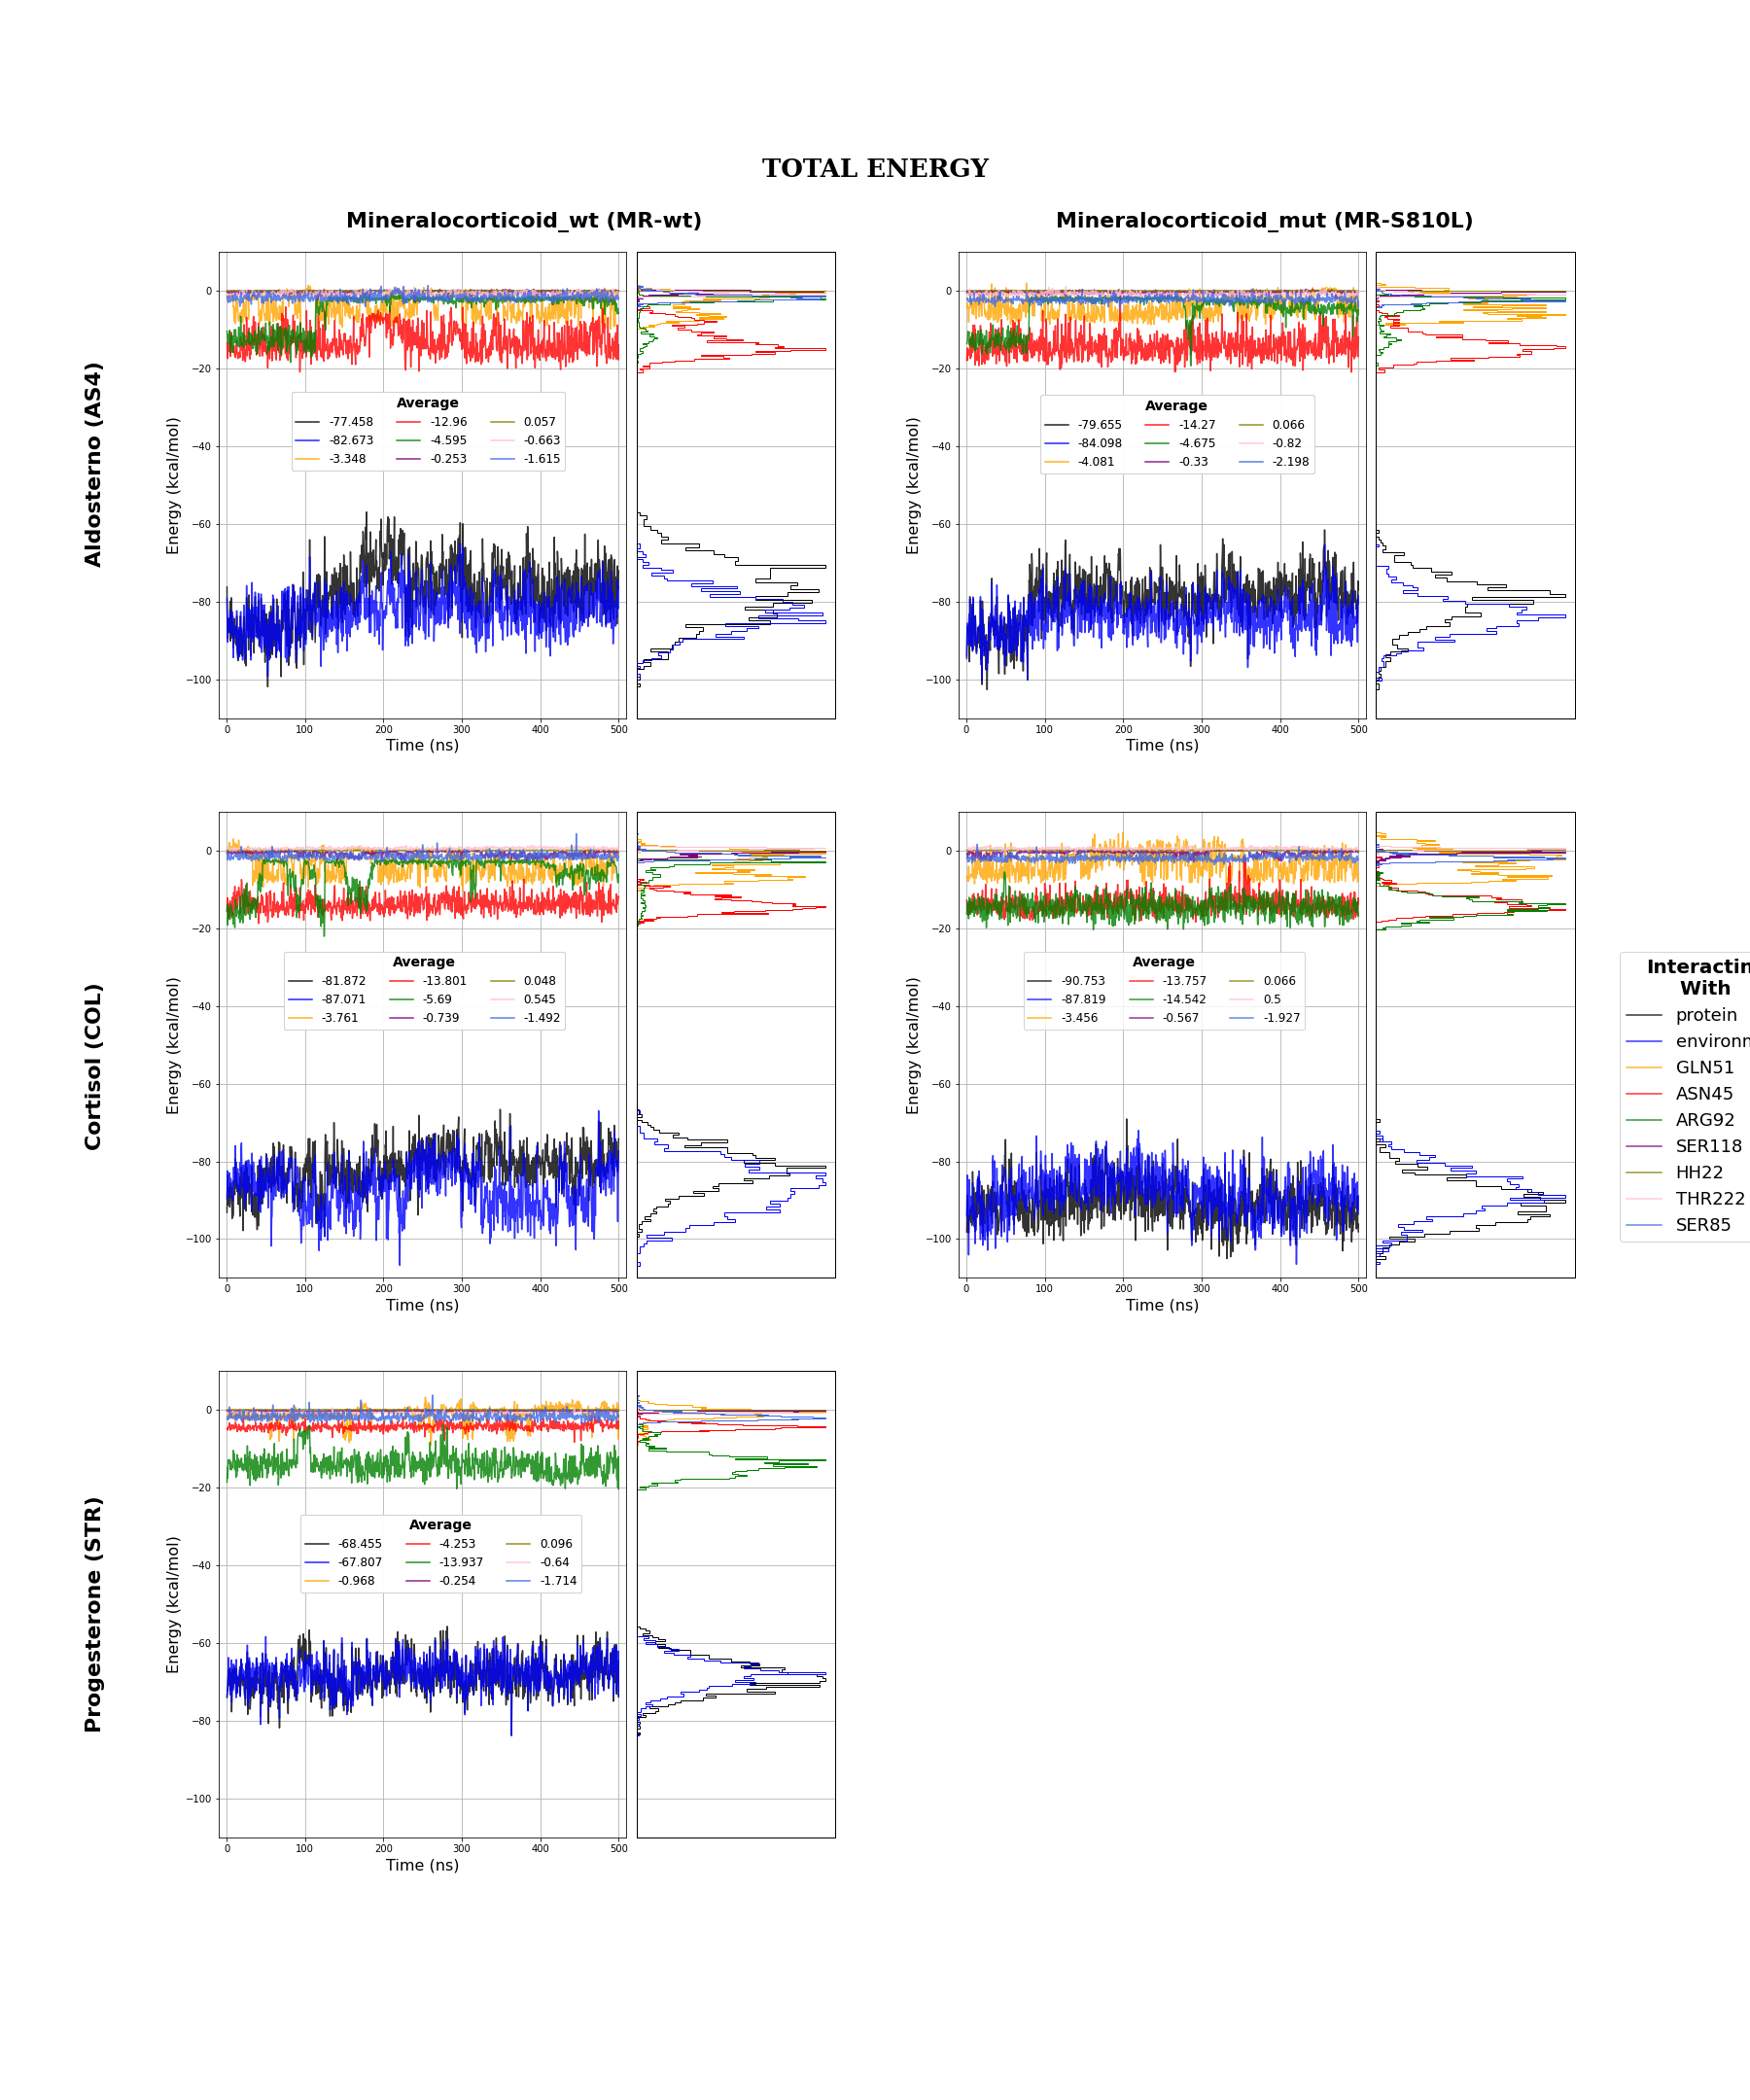

In [40]:
#@title Plot Energies 
fig = PlotEnergiesShort(work_directories, bins=100, bins_cum=50, ncol=3)
fig.savefig("./Energies.png", transparent=True, bbox_inches='tight')